In [201]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np
import yaml
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.linalg import block_diag
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from JOPLEn.multitask import MTJOPLEn
from JOPLEn.partitioner import VPartition, LinearForestPartition, GBPartition
from JOPLEn.enums import NormType
from sklearn.ensemble import GradientBoostingRegressor
from JOPLEn.singletask import JOPLEn
from collections import defaultdict


DATA_PATH = Path("..") / "datasets"

SARCOS_PATH = DATA_PATH / "sarcos" / "processed"
PARKINSONS_PATH = DATA_PATH / "parkinsons" / "processed"
NANO_PATH = DATA_PATH / "nanoparticle" / "processed"

In [160]:
def train_model(ModelClass, x_train, y_train, x_val, y_val, x_test, y_test, **kwargs):
    output = {}
    model = ModelClass(**kwargs)

    for i in tqdm(range(x_train.shape[0])):
        model.fit(x_train[i], y_train[i])

        output[f"task {i}"] = {
            "train": np.mean((model.predict(x_train[i]) - y_train[i]) ** 2),
            "val": np.mean((model.predict(x_val[i]) - y_val[i]) ** 2),
            "test": np.mean((model.predict(x_test[i]) - y_test[i]) ** 2),
        }
    return pd.DataFrame(output).T

In [193]:
def jp_mask(jp_model):
    core_mask = np.linalg.norm(jp_model.cwb.get()[:, :-1], axis=(0, 2)) > 1e-4
    task_mask = np.linalg.norm(jp_model.cws.get()[:, :-1], axis=2) > 1e-4

    task_mask = task_mask & ~core_mask[None, :]

    return core_mask, task_mask


def dl_mask(dl_model):
    core_mask = np.any(np.abs(dl_model.coef_shared_.T) > 1e-4, axis=0)
    task_mask = np.abs(dl_model.coef_specific_.T) > 1e-4

    task_mask = task_mask & ~core_mask[None, :]

    return core_mask, task_mask

In [182]:
def dl_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2, axis=1)


def score_dl(model, x_train, y_train, x_val, y_val, x_test, y_test):
    y_train_err = dl_mse(y_train, model.predict(x_train))
    y_val_err = dl_mse(y_val, model.predict(x_val))
    y_test_err = dl_mse(y_test, model.predict(x_test))

    columns = ["train", "val", "test"]
    index = [f"task {i}" for i in range(x_train.shape[0])]

    return pd.DataFrame(
        np.array([y_train_err, y_val_err, y_test_err]).T,
        columns=columns,
        index=index,
    )


def dl_plot(model):
    fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True)

    axs[0].matshow(model.coef_shared_.T)
    axs[0].set_title("Shared Coefficients")

    axs[1].matshow(model.coef_specific_.T)
    axs[1].set_title("Specific Coefficients")

    for ax in axs:
        ax.set_xlabel("Features")
        ax.set_ylabel("Tasks")

    plt.tight_layout()

    core_mask, task_mask = dl_mask(model)

    print("Core features:", np.sum(core_mask))
    print(f"Task features: {list(np.sum(task_mask, axis=1))}: {np.sum(task_mask)}")

In [163]:
def scale_matrix(matrix, min_val, max_val):
    # Create an empty matrix of the same shape to store the scaled values
    scaled_matrix = np.zeros_like(matrix)

    assert min_val < 0 and max_val > 0, "min_val and max_val must have opposite signs"

    abs_max = max(abs(min_val), abs(max_val))

    # Handle negative and zero values
    neg_mask = matrix <= 0
    scaled_matrix[neg_mask] = matrix[neg_mask] / abs_max

    # Handle positive values
    pos_mask = matrix > 0
    scaled_matrix[pos_mask] = matrix[pos_mask] / abs_max

    return scaled_matrix


def plot_joplen_weights(model):
    core_weights = model.cwb.get()
    task_weights = model.cws.get()

    min_val = min(core_weights.min(), task_weights.min())
    max_val = max(core_weights.max(), task_weights.max())

    n_tasks, n_feats, n_cells = core_weights.shape
    core_weights = core_weights.transpose(1, 0, 2).reshape(n_feats, -1)
    task_weights = task_weights.transpose(1, 0, 2).reshape(n_feats, -1)

    core_weights = scale_matrix(core_weights, min_val, max_val)
    task_weights = scale_matrix(task_weights, min_val, max_val)

    fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharey=True, sharex=True, dpi=300)

    params = {"aspect": "auto", "vmin": -1, "vmax": 1, "cmap": "seismic"}

    axs[0].matshow(core_weights, **params)
    axs[0].set_title("Core Weights")
    axs[1].matshow(task_weights, **params)
    axs[1].set_title("Task Weights")

    # create a vertical line between each task
    for ax in axs:
        for i in range(n_tasks - 1):
            ax.axvline((i + 1) * n_cells, color="k", linewidth=1, alpha=0.25)

    for ax in axs:
        ax.set_xlabel("Tasks, partitions, and cells")
        ax.set_ylabel("Features")

    plt.tight_layout()
    plt.show()

    # print the number of weights that are nonzero
    core_mask, task_mask = jp_mask(model)

    print(f"Number of nonzero core weights: {core_mask.sum()}")
    print(
        f"Number of nonzero task weights: {list(task_mask.sum(axis=1))}: {task_mask.sum()}"
    )

In [213]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def score_jp(model: MTJOPLEn, x_train, y_train, x_val, y_val, x_test, y_test):
    y_train_err = []
    y_val_err = []
    y_test_err = []

    for i in range(x_train.shape[0]):
        y_train_err.append(mse(y_train[i], model.predict(x_train[i], i).flatten()))
        y_val_err.append(mse(y_val[i], model.predict(x_val[i], i).flatten()))
        y_test_err.append(mse(y_test[i], model.predict(x_test[i], i).flatten()))

    columns = ["train", "val", "test"]
    index = [f"task {i}" for i in range(x_train.shape[0])]

    return pd.DataFrame(
        np.array([y_train_err, y_val_err, y_test_err]).T,
        columns=columns,
        index=index,
    )


def compare_feats(jp_model, dl_model, x_train, y_train, x_val, y_val, x_test, y_test):
    jp_core_feats, jp_task_feats = jp_mask(jp_model)
    dl_core_feats, dl_task_feats = dl_mask(dl_model)

    x_ds = [x_train, x_val, x_test]
    y_ds = [y_train, y_val, y_test]
    names = ["train", "val", "test"]

    feat_groups = [
        ("joplen", jp_core_feats | jp_task_feats),
        ("dl", dl_core_feats | dl_task_feats),
    ]

    results = defaultdict(lambda: defaultdict(list))

    for name, feats in feat_groups:
        for x, y, ds_name in zip(x_ds, y_ds, names):
            for i, _ in enumerate(x):
                lgbm = LGBMRegressor(random_state=0, verbose=-1)
                lgbm.fit(x[i][:, feats[i]], y[i].flatten())
                y_pred = lgbm.predict(x[i][:, feats[i]])
                results[name][ds_name].append(mse(y[i].flatten(), y_pred))

    results = {k: dict(v) for k, v in results.items()}

    df = pd.DataFrame.from_dict(
        {(i, j): results[i][j] for i in results.keys() for j in results[i].keys()},
        orient="index",
    )
    df.index = pd.MultiIndex.from_tuples(df.index)

    return df

In [165]:
# try sarcos

x_train = np.loadtxt(SARCOS_PATH / "x_train.csv", delimiter=",")
x_val = np.loadtxt(SARCOS_PATH / "x_val.csv", delimiter=",")
x_test = np.loadtxt(SARCOS_PATH / "x_test.csv", delimiter=",")

y_train = np.loadtxt(SARCOS_PATH / "y_train.csv", delimiter=",")
y_val = np.loadtxt(SARCOS_PATH / "y_val.csv", delimiter=",")
y_test = np.loadtxt(SARCOS_PATH / "y_test.csv", delimiter=",")

x_ss = StandardScaler()
x_train = x_ss.fit_transform(x_train)
x_val = x_ss.transform(x_val)
x_test = x_ss.transform(x_test)

y_ss = StandardScaler()
y_train = y_ss.fit_transform(y_train)
y_val = y_ss.transform(y_val)
y_test = y_ss.transform(y_test)

print(x_train.shape, y_train.shape)

n_tasks = y_train.shape[1]

x_train = np.tile(x_train, (n_tasks, 1, 1))
x_val = np.tile(x_val, (n_tasks, 1, 1))
x_test = np.tile(x_test, (n_tasks, 1, 1))

y_train = np.transpose(y_train)
y_val = np.transpose(y_val)
y_test = np.transpose(y_test)

print(x_train.shape, y_train.shape)

(34262, 21) (34262, 7)
(7, 34262, 21) (7, 34262)


In [166]:
shared_params = {
    "x_train": x_train,
    "y_train": y_train,
    "x_val": x_val,
    "y_val": y_val,
    "x_test": x_test,
    "y_test": y_test,
}

dummy_results = train_model(DummyRegressor, **shared_params, strategy="mean")
linear_results = train_model(LinearRegression, **shared_params)
gb_results = train_model(
    LGBMRegressor,
    random_state=0,
    n_estimators=1000,
    verbose=-1,
    **shared_params,
)

print("Dummy Results")
display(dummy_results.round(3))
print("Linear Results")
display(linear_results.round(3))
print("GB Results")
display(gb_results.round(3))

100%|██████████| 7/7 [00:07<00:00,  1.11s/it]

Dummy Results


,train,val,test
task 0,1.0,1.032,0.983
task 1,1.0,1.011,0.978
task 2,1.0,1.019,0.991
task 3,1.0,1.020,0.979
task 4,1.0,1.037,1.010
task 5,1.0,0.994,0.973
task 6,1.0,1.010,0.984


Linear Results


,train,val,test
task 0,0.074,0.074,0.074
task 1,0.103,0.102,0.102
task 2,0.091,0.094,0.090
task 3,0.051,0.053,0.050
task 4,0.146,0.151,0.144
task 5,0.274,0.277,0.271
task 6,0.065,0.067,0.064


GB Results


,train,val,test
task 0,0.004,0.016,0.014
task 1,0.003,0.013,0.012
task 2,0.003,0.010,0.010
task 3,0.001,0.004,0.004
task 4,0.004,0.016,0.015
task 5,0.005,0.018,0.018
task 6,0.002,0.007,0.007


(21,)
[False  True False False False False False False False False False False
 False False  True  True  True  True False False False]
Core features: 5
Task features: [3, 3, 3, 2, 8, 5, 3]: 27


,train,val,test
task 0,0.105,0.103,0.104
task 1,0.125,0.124,0.121
task 2,0.107,0.110,0.102
task 3,0.070,0.071,0.069
task 4,0.194,0.201,0.192
task 5,0.335,0.337,0.327
task 6,0.095,0.096,0.095


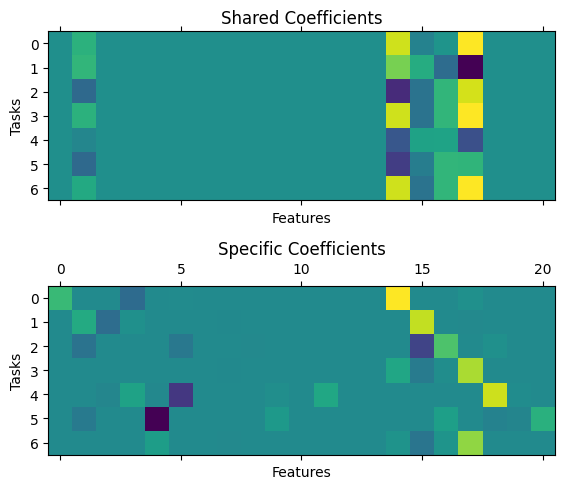

In [188]:
from mutar import DirtyModel

dl_model = DirtyModel(
    alpha=0.1,  # shared penalty
    beta=0.0442,  # task-specific penalty
)
dl_model.fit(x_train, y_train)

dl_plot(dl_model)

dl_res = score_dl(dl_model, x_train, y_train, x_val, y_val, x_test, y_test)
display(dl_res.round(3))

In [237]:
vpart_params = (
    {"n_partitions": 100, "n_cells": 8},
    {
        "max_iters": 1000,
        "lam_core": 0.38,
        "lam_task": 0.15,
        "core_alpha": 0.0,
        "task_alpha": 0.0,
        "print_epochs": 10,
        "mu": 0.1,
    },
)

jp_model = MTJOPLEn(
    GBPartition,
    # VPartition,
    **vpart_params[0],
    random_state=0,
)
history = jp_model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    **vpart_params[1],
    verbose=True,
)

[20:25:15]: Epoch     10 | TrL: 0.550666, 0.455598, 0.402939, 0.393120, 0.470703, 0.573680, 0.401745 | VaL: 0.555423, 0.452419, 0.405475, 0.401292, 0.481388, 0.573598, 0.406509 | CNorm: 36.865257 | TNorm: 87.382782 | CFNorm: 0.850042 | TFNorm: 0.850042 | WbNz:   22 | WsNz:    0,    0,    0,    0,    0,    0,    0
[20:25:15]: Epoch     20 | TrL: 0.448462, 0.386696, 0.355463, 0.340799, 0.415335, 0.504030, 0.352077 | VaL: 0.450482, 0.383702, 0.359061, 0.347200, 0.424434, 0.505122, 0.355574 | CNorm: 42.176697 | TNorm: 98.504364 | CFNorm: 1.238244 | TFNorm: 1.238244 | WbNz:   22 | WsNz:    0,    0,    0,    0,    0,    0,    0
[20:25:15]: Epoch     30 | TrL: 0.405539, 0.356463, 0.334929, 0.315529, 0.394450, 0.473030, 0.328176 | VaL: 0.406622, 0.353874, 0.338921, 0.321156, 0.403307, 0.474751, 0.331115 | CNorm: 44.000946 | TNorm: 102.508392 | CFNorm: 1.506072 | TFNorm: 1.506072 | WbNz:   21 | WsNz:    0,    0,    1,    0,    0,    1,    0
[20:25:15]: Epoch     40 | TrL: 0.382929, 0.339816, 0.

,train,val,test
task 0,0.084,0.083,0.081
task 1,0.087,0.086,0.084
task 2,0.075,0.077,0.071
task 3,0.055,0.057,0.054
task 4,0.120,0.125,0.123
task 5,0.159,0.162,0.153
task 6,0.072,0.072,0.071


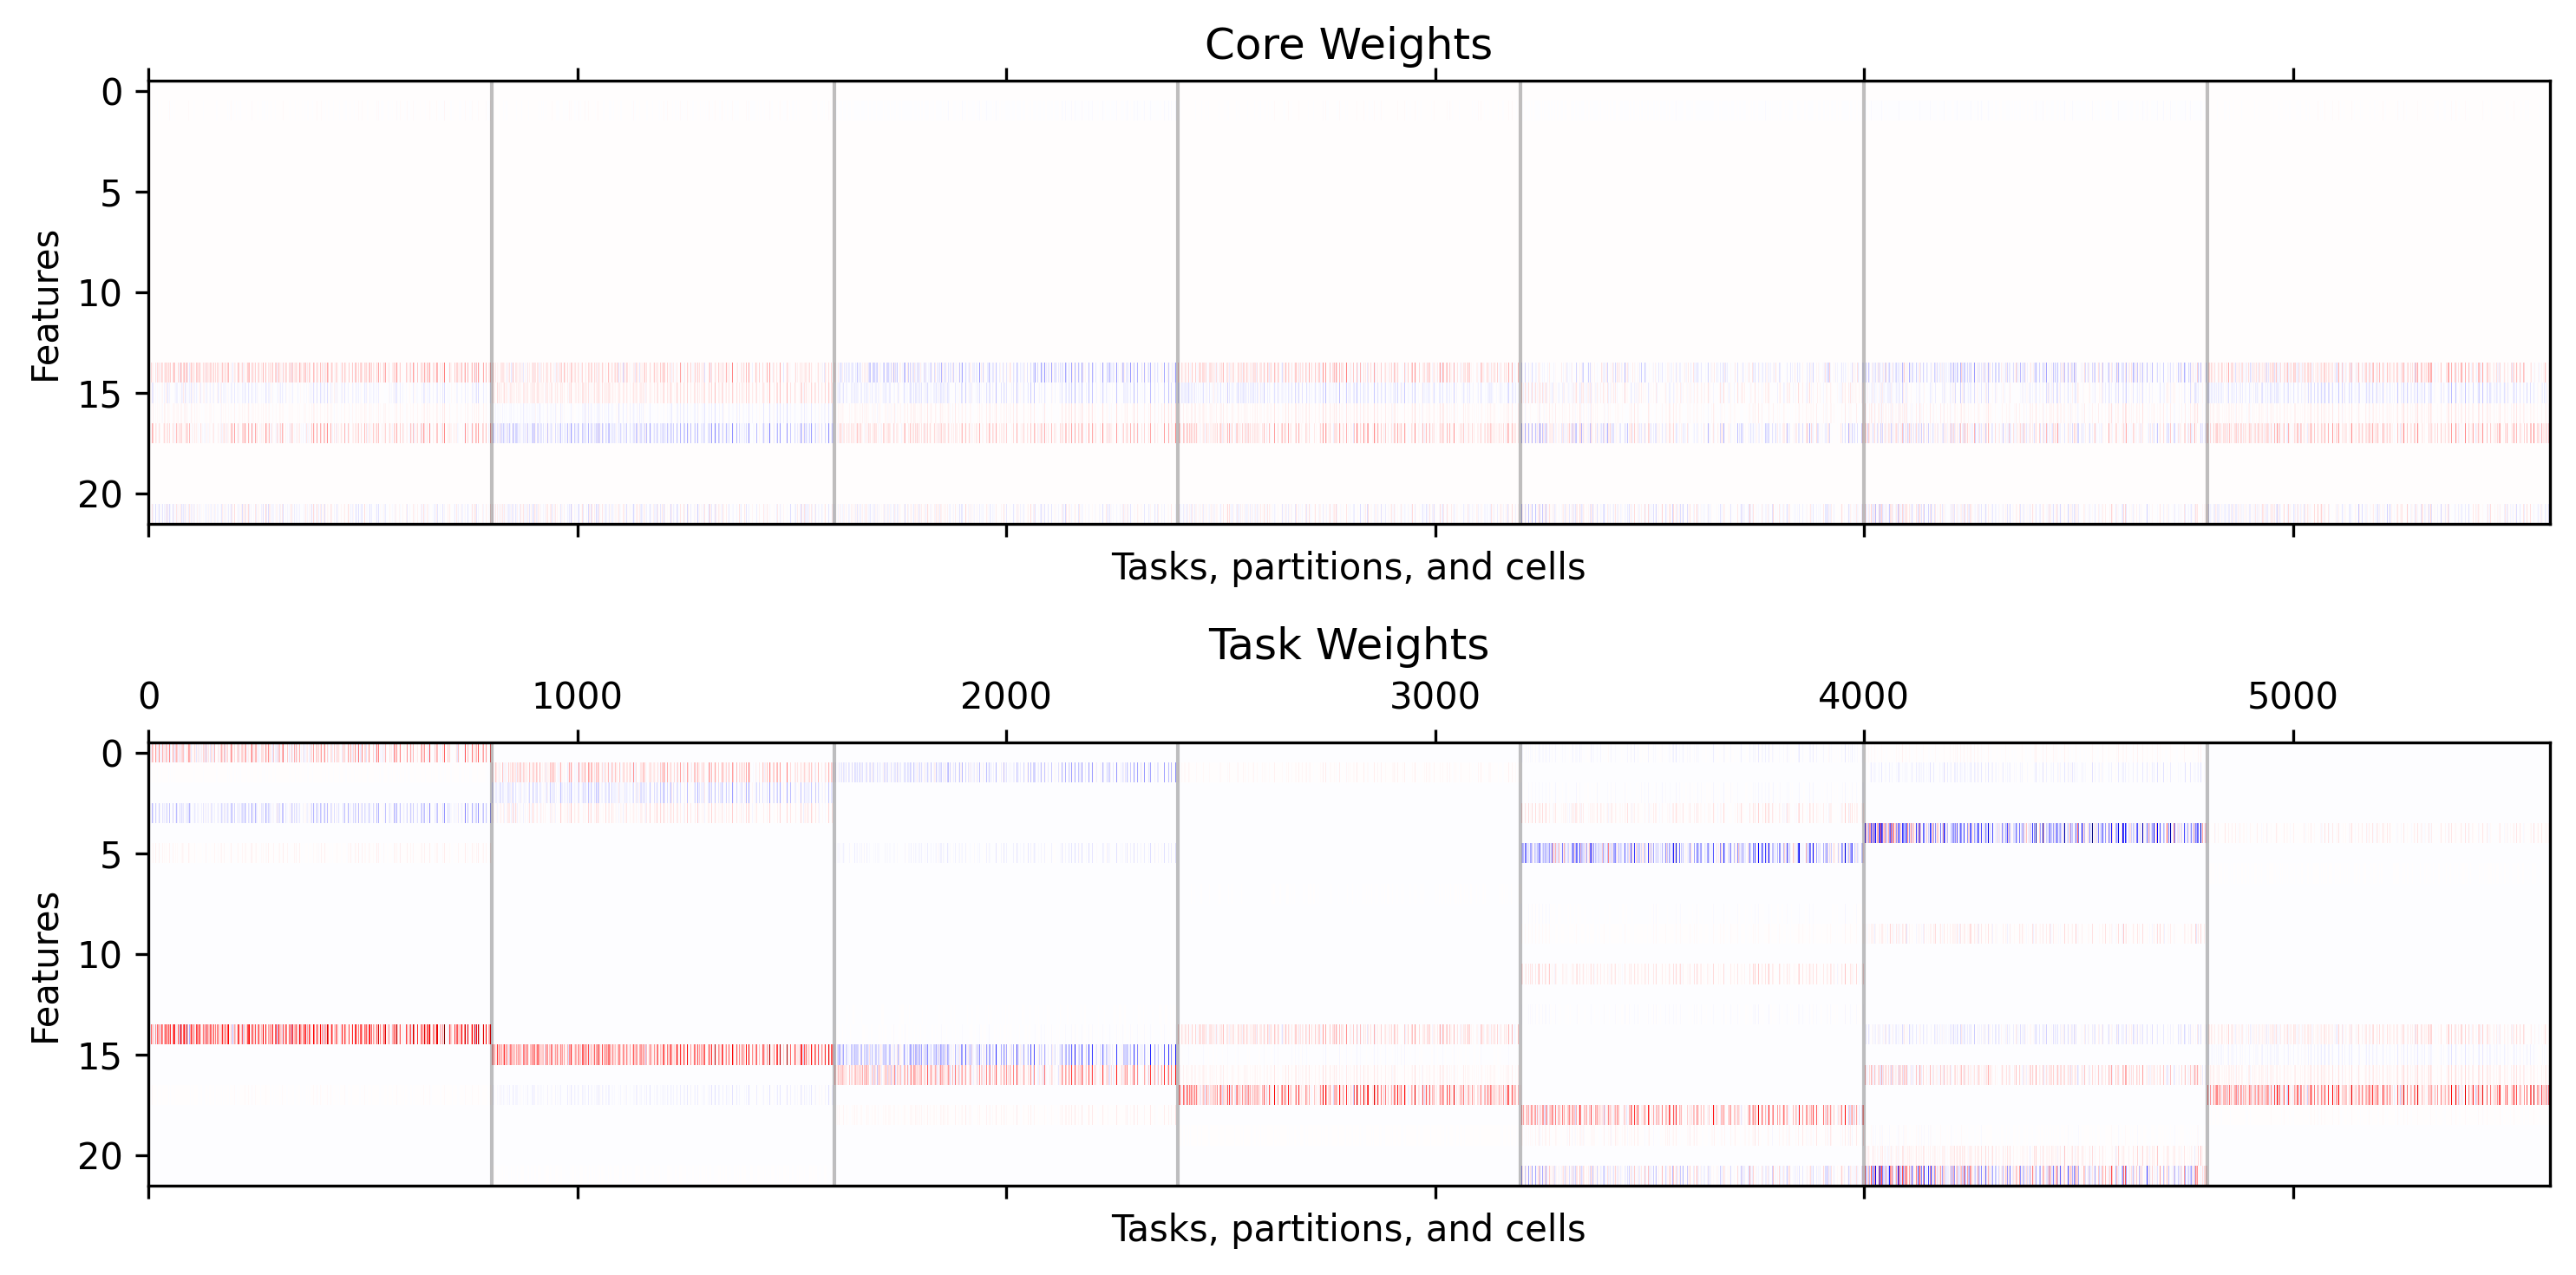

(7, 21, 800)
Number of nonzero core weights: 5
Number of nonzero task weights: [3, 2, 3, 2, 10, 5, 3]: 28


In [238]:
jp_res = score_jp(jp_model, x_train, y_train, x_val, y_val, x_test, y_test)

display(jp_res.round(3))

plot_joplen_weights(jp_model)

In [239]:
sarcos_df = compare_feats(
    jp_model, dl_model, x_train, y_train, x_val, y_val, x_test, y_test
)
sarcos_df.xs("test", level=1).round(3)

(7, 21, 800)
(21,)


,0,1,2,3,4,5,6
joplen,0.025,0.024,0.019,0.01,0.024,0.035,0.017
dl,0.025,0.021,0.019,0.01,0.022,0.036,0.016


---

In [ ]:
# try parkinsons

train = {}
val = {}
test = {}

for dir in sorted(PARKINSONS_PATH.iterdir(), key=lambda x: int(x.name)):
    x_train = np.loadtxt(dir / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(dir / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(dir / "x_test.csv", delimiter=",")

    x_ss = StandardScaler()
    x_train = x_ss.fit_transform(x_train)
    x_val = x_ss.transform(x_val)
    x_test = x_ss.transform(x_test)

    y_train = np.loadtxt(dir / "y_train.csv", delimiter=",")[:, None]
    y_val = np.loadtxt(dir / "y_val.csv", delimiter=",")[:, None]
    y_test = np.loadtxt(dir / "y_test.csv", delimiter=",")[:, None]

    y_ss = StandardScaler()
    y_train = y_ss.fit_transform(y_train).flatten()
    y_val = y_ss.transform(y_val).flatten()
    y_test = y_ss.transform(y_test).flatten()

    train[int(dir.name)] = {"x": x_train, "y": y_train}
    val[int(dir.name)] = {"x": x_val, "y": y_val}
    test[int(dir.name)] = {"x": x_test, "y": y_test}

In [ ]:
n_tasks = len(train)
participants = list(train.keys())

x_train = [train[i]["x"] for i in participants]
x_val = [val[i]["x"] for i in participants]
x_test = [test[i]["x"] for i in participants]

y_train = [train[i]["y"] for i in participants]
y_val = [val[i]["y"] for i in participants]
y_test = [test[i]["y"] for i in participants]

In [ ]:
from JOPLEn.partitioner import VPartition, RFPartition, GBPartition

model = MTJOPLEn(
    # GBPartition,
    # n_partitions=100,
    VPartition,
    n_partitions=100,
    n_cells=2,
    random_state=0,
)

history = model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    max_iters=100,
    lam_core=5.0,
    lam_task=1.5,
    core_alpha=0.0,
    task_alpha=0.0,
    print_epochs=2,
    mu=0.05,
)

[08:58:51]: Epoch      2 | TrL: 0.973752, 0.984168, 0.974475, 0.957034, 0.975385, 0.971719, 0.979363, 0.997430, 0.990431, 0.986618, 0.976289, 0.987215, 0.974521, 0.988867, 0.874309, 0.956133, 0.988485, 0.961819, 0.983464, 0.994126, 0.979674, 0.987847, 0.940729, 0.988954, 0.969936, 0.973085, 0.957147, 0.990156, 0.979949, 0.987736, 0.986883, 0.973031, 0.973052, 0.983433, 0.988629, 0.993306, 0.893418, 0.996763, 0.992229, 0.991984, 0.987152, 0.946049 | VaL: 1.012833, 0.930916, 0.887174, 1.085590, 0.905062, 1.001942, 0.998761, 1.026359, 1.215390, 0.921090, 1.047837, 1.033548, 0.938188, 1.049641, 1.038259, 1.122838, 0.996906, 0.879304, 0.945761, 1.092421, 0.991088, 0.995449, 0.860058, 1.163720, 1.072610, 0.968785, 1.006395, 1.384542, 0.878234, 0.942058, 1.011372, 0.998808, 0.926146, 1.089644, 1.047581, 0.997370, 0.970816, 0.900452, 1.044624, 1.297419, 1.020157, 1.030537 | CNorm: 7.012942 | TNorm: 15.365116 | CFNorm: 0.016387 | TFNorm: 0.016387 | WbNz:   17 | WsNz:    0,    0,    0,    0,    

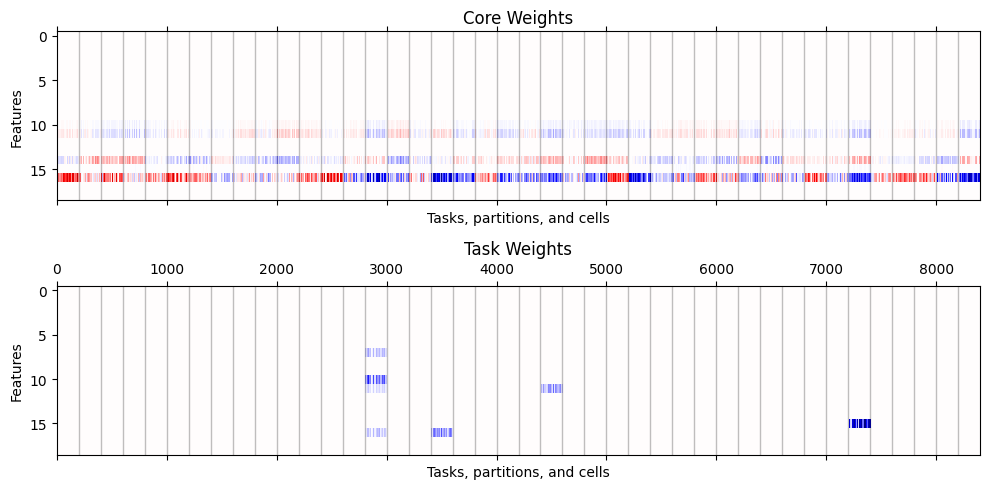

In [ ]:
plot_joplen_weights(model)

In [150]:
def plot_strip(
    arr: list[np.ndarray],
    jitter: float = 0.2,
    random_state: int = 0,
    plot_kwargs: dict = {},
    scatter_kwargs: dict = {},
    ax=None,
):
    """
    Create a strip plot based on the list of y-values.
    """
    if ax is None:
        fig, ax = plt.subplots(**plot_kwargs)

    np.random.seed(random_state)
    y_values = np.arange(len(arr))[:, None] + np.random.uniform(
        -jitter, jitter, size=arr.shape
    )

    for xs, ys in zip(arr, y_values):
        ax.scatter(xs, ys, **scatter_kwargs)

    # for x_idx, x_values in enumerate(arr):
    #     # Apply jitter to x-axis positions
    #     y_values = [x_idx + np.random.uniform(-jitter, jitter) for _ in x_values]
    #     ax.scatter(x_values, y_values, **scatter_kwargs)

    x_lim = ax.get_xlim()

    for x_idx, x_values in enumerate(arr[:-1]):
        ax.hlines(x_idx + 1 / 2, *x_lim, color="k", alpha=0.25)

    ax.set_xlim(x_lim)
    ax.set_ylim(-0.5, len(arr) - 0.5)

    return ax, y_values

In [157]:
core_mask = np.linalg.norm(model.cwb.get(), axis=(0, 2))[:-1] > 1e-4
task_mask = np.linalg.norm(model.cws.get(), axis=2)[:, :-1] > 1e-4
feature_mask = np.logical_or(core_mask, task_mask)
print(feature_mask.sum())

y_train_pred, y_val_pred, y_test_pred = [], [], []
y_train_err, y_val_err, y_test_err = [], [], []

for i in range(n_tasks):
    lgbm = LGBMRegressor(random_state=0, verbose=-1)
    lgbm.fit(x_train[i][:, feature_mask[i]], y_train[i])

    y_train_pred.append(lgbm.predict(x_train[i][:, feature_mask[i]]))
    y_val_pred.append(lgbm.predict(x_val[i][:, feature_mask[i]]))
    y_test_pred.append(lgbm.predict(x_test[i][:, feature_mask[i]]))

    y_train_err.append(np.mean((y_train_pred[-1] - y_train[i]) ** 2))
    y_val_err.append(np.mean((y_val_pred[-1] - y_val[i]) ** 2))
    y_test_err.append(np.mean((y_test_pred[-1] - y_test[i]) ** 2))

211


In [159]:
def concat_datasets(
    X_datasets: list[np.ndarray], y_datasets: list[np.ndarray]
) -> tuple[np.ndarray]:
    padded_y = []
    padded_X = []
    mask = []

    num_datasets = len(y_datasets)
    max_samples = max([y.shape[0] for y in y_datasets])
    basis = np.eye(num_datasets, dtype=bool)

    for i, (y, X, b) in enumerate(zip(y_datasets, X_datasets, basis)):
        y = np.expand_dims(y, 0)
        X = np.expand_dims(X, 0)
        b = np.expand_dims(b, 1)

        task_padding = (i, num_datasets - i - 1)

        tmp_y = np.pad(y, [task_padding, (0, 0)], mode="constant")
        tmp_X = np.tile(X, (num_datasets, 1, 1))
        tmp_b = np.tile(b, (1, y.shape[1]))

        padded_y.append(tmp_y)
        padded_X.append(tmp_X)
        mask.append(tmp_b)

    y_out = np.concatenate(padded_y, axis=-1)
    x_out = np.concatenate(padded_X, axis=1)
    mask_out = np.concatenate(mask, axis=-1)

    return x_out, y_out, mask_out


def get_out_data(y_pred, mask_out):
    indices = [0] + list(np.cumsum(mask_out.sum(axis=1)))[:-1] + [None]
    tmp = y_pred[mask_out]
    return [tmp[i1:i2] for i1, i2 in zip(indices[:-1], indices[1:])]

In [183]:
from mutar import DirtyModel

x_train_out, y_train_out, train_mask_out = concat_datasets(x_train, y_train)
x_val_out, y_val_out, val_mask_out = concat_datasets(x_val, y_val)
x_test_out, y_test_out, test_mask_out = concat_datasets(x_test, y_test)

model = DirtyModel(
    alpha=0.015,  # shared penalty
    beta=0.005,  # task-specific penalty
)
model.fit(x_train_out, y_train_out, train_mask_out)

DirtyModel(alpha=0.015, beta=0.005)

In [184]:
core_mask = np.linalg.norm(model.coef_shared_.T, axis=0) > 1e-4
task_mask = model.coef_specific_.T > 1e-4
feature_mask = np.logical_or(core_mask, task_mask)
print(feature_mask.sum())

dl_train_pred, dl_val_pred, dl_test_pred = [], [], []
dl_train_err, dl_val_err, dl_test_err = [], [], []

for i in range(n_tasks):
    lgbm = LGBMRegressor(random_state=0, verbose=-1)
    lgbm.fit(x_train[i][:, feature_mask[i]], y_train[i])

    dl_train_pred.append(lgbm.predict(x_train[i][:, feature_mask[i]]))
    dl_val_pred.append(lgbm.predict(x_val[i][:, feature_mask[i]]))
    dl_test_pred.append(lgbm.predict(x_test[i][:, feature_mask[i]]))

    dl_train_err.append(np.mean((dl_train_pred[-1] - y_train[i]) ** 2))
    dl_val_err.append(np.mean((dl_val_pred[-1] - y_val[i]) ** 2))
    dl_test_err.append(np.mean((dl_test_pred[-1] - y_test[i]) ** 2))

174


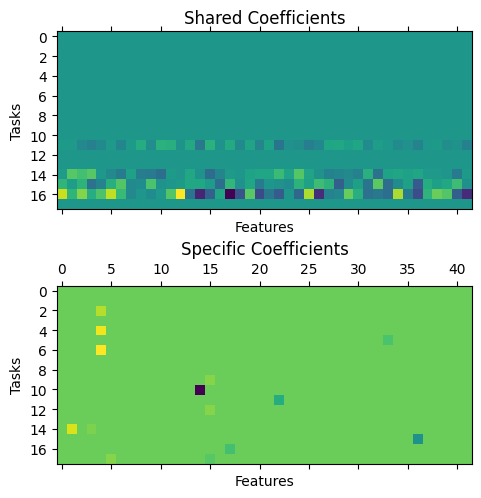

In [185]:
fig, axs = plt.subplots(2, 1, figsize=(5, 5), sharey=True, sharex=True)

axs[0].matshow(model.coef_shared_)
axs[0].set_title("Shared Coefficients")

axs[1].matshow(model.coef_specific_)
axs[1].set_title("Specific Coefficients")

for ax in axs:
    ax.set_xlabel("Features")
    ax.set_ylabel("Tasks")

plt.tight_layout()
plt.show()

In [186]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor


def train_model(ModelClass, **kwargs):
    output = {}
    model = ModelClass(**kwargs)

    for i in tqdm(range(n_tasks)):
        model.fit(x_train[i], y_train[i])

        output[f"task {i}"] = {
            "train": np.mean((model.predict(x_train[i]) - y_train[i]) ** 2),
            "val": np.mean((model.predict(x_val[i]) - y_val[i]) ** 2),
            "test": np.mean((model.predict(x_test[i]) - y_test[i]) ** 2),
        }
    return output


linear_results = train_model(LinearRegression)
naive_results = train_model(DummyRegressor, strategy="mean")
linear_test_err = [linear_results[f"task {i}"]["test"] for i in range(n_tasks)]
naive_test_err = [naive_results[f"task {i}"]["test"] for i in range(n_tasks)]

100%|██████████| 42/42 [00:00<00:00, 5483.60it/s]


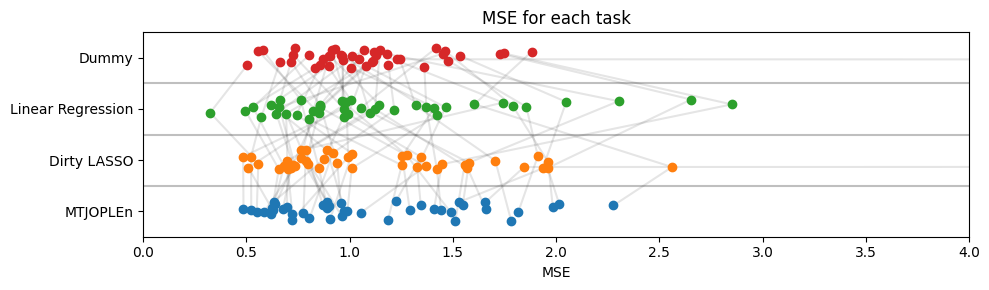

In [187]:
columns = ["train", "val", "test"]
index = [f"task {i}" for i in range(n_tasks)]

data = np.vstack([y_test_err, dl_test_err, linear_test_err, naive_test_err])

fig, ax = plt.subplots(figsize=(10, 3))

ax, y_values = plot_strip(
    data,
    scatter_kwargs={"marker": "o"},
    ax=ax,
)

ax.plot(data.reshape(4, -1), y_values, color="k", alpha=0.1, zorder=0)

ax.set_xlabel("MSE")
ax.set_yticks(range(4), ["MTJOPLEn", "Dirty LASSO", "Linear Regression", "Dummy"])
ax.set_title("MSE for each task")

ax.set_xlim(0, 4)
plt.tight_layout()
plt.show()

---

In [236]:
train = {}
val = {}
test = {}

dirs = sorted(NANO_PATH.iterdir())
dir_names = [dir.name for dir in dirs]

for dir in dirs:
    x_train = np.loadtxt(dir / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(dir / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(dir / "x_test.csv", delimiter=",")

    x_ss = StandardScaler()
    x_train = x_ss.fit_transform(x_train)
    x_val = x_ss.transform(x_val)
    x_test = x_ss.transform(x_test)

    y_train = np.loadtxt(dir / "y_train.csv", delimiter=",")[:, None]
    y_val = np.loadtxt(dir / "y_val.csv", delimiter=",")[:, None]
    y_test = np.loadtxt(dir / "y_test.csv", delimiter=",")[:, None]

    y_ss = StandardScaler()
    y_train = y_ss.fit_transform(y_train).flatten()
    y_val = y_ss.transform(y_val).flatten()
    y_test = y_ss.transform(y_test).flatten()

    train[dir.name] = {"x": x_train, "y": y_train}
    val[dir.name] = {"x": x_val, "y": y_val}
    test[dir.name] = {"x": x_test, "y": y_test}

In [237]:
n_tasks = len(train)
participants = list(train.keys())

x_train = [train[i]["x"] for i in participants]
x_val = [val[i]["x"] for i in participants]
x_test = [test[i]["x"] for i in participants]

y_train = [train[i]["y"] for i in participants]
y_val = [val[i]["y"] for i in participants]
y_test = [test[i]["y"] for i in participants]

In [238]:
jp_model = MTJOPLEn(
    # GBPartition,
    # n_partitions=100,
    VPartition,
    n_partitions=100,
    n_cells=2,
    random_state=0,
)

history = jp_model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    max_iters=10000,
    # lam_core=8,
    # lam_task=100,
    lam_core=0.4,
    lam_task=0.3,
    core_alpha=0.0,
    task_alpha=0.0,
    print_epochs=100,
    mu=0.003,
    norm_type=NormType.L21,
    threshold=1e-4,
)

# 8
# [ 0 20 81 10  0  0  0]
# Train: [0.17, 0.09, 0.19, 0.08, 0.3, 0.28, 0.33]
# Val:   [0.57, 0.33, 0.29, 0.4, 0.46, 1.06, 0.77]
# Test:  [0.63, 0.28, 0.29, 0.38, 0.57, 0.63, 0.86]

[09:34:21]: Epoch    100 | TrL: 0.867186, 0.784022, 0.679030, 0.809682, 0.947097, 0.928715, 0.966590 | VaL: 0.847988, 0.735201, 0.680992, 0.824206, 1.028018, 1.194365, 0.982616 | CNorm: 19.221792 | TNorm: 9.429960 | CFNorm: 0.006786 | TFNorm: 0.006786 | WbNz:  402 | WsNz:    0,    0,   28,    0,    0,    0,    0
[09:34:22]: Epoch    200 | TrL: 0.862877, 0.776225, 0.672868, 0.799004, 0.940122, 0.921592, 0.963549 | VaL: 0.843277, 0.726383, 0.674874, 0.812894, 1.022277, 1.193385, 0.980105 | CNorm: 20.289038 | TNorm: 8.212170 | CFNorm: 0.009019 | TFNorm: 0.009019 | WbNz:  334 | WsNz:    0,    0,   30,    0,    0,    0,    0
[09:34:22]: Epoch    300 | TrL: 0.859945, 0.769949, 0.670408, 0.793114, 0.933750, 0.918050, 0.961584 | VaL: 0.841289, 0.720981, 0.672924, 0.806249, 1.016920, 1.192138, 0.978549 | CNorm: 21.058338 | TNorm: 7.520025 | CFNorm: 0.010481 | TFNorm: 0.010481 | WbNz:  276 | WsNz:    0,    0,   38,    0,    0,    0,    0
[09:34:22]: Epoch    400 | TrL: 0.858981, 0.766380, 0.6691

In [190]:
jp_model = MTJOPLEn(
    LinearForestPartition,
    n_partitions=10,
    n_cells=4,
    random_state=0,
)

history = jp_model.fit(
    x_train,
    y_train,
    lst_val_x=x_val,
    lst_val_y=y_val,
    max_iters=10000,
    # lam_core=8,
    # lam_task=100,
    lam_core=0.8,
    lam_task=0.5,
    core_alpha=0.0,
    task_alpha=0.0,
    print_epochs=100,
    mu=0.003,
    norm_type=NormType.LINF1,
    threshold=1e-4,
)

/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the p

[09:08:31]: Epoch    100 | TrL: 0.799105, 0.691799, 0.667390, 0.763686, 0.802371, 0.842466, 0.915956 | VaL: 0.802098, 0.669733, 1.723345, 0.777802, 0.902139, 1.124071, 0.935927 | CNorm: 11.728550 | TNorm: 0.817025 | CFNorm: 0.003545 | TFNorm: 0.003545 | WbNz: 1058 | WsNz:    0,    0,    0,    0,    0,    0,    0
[09:08:32]: Epoch    200 | TrL: 0.773697, 0.662072, 0.653315, 0.736892, 0.758263, 0.816031, 0.900333 | VaL: 0.783820, 0.654050, 1.859746, 0.749227, 0.864157, 1.095738, 0.923113 | CNorm: 13.836845 | TNorm: 0.661705 | CFNorm: 0.003804 | TFNorm: 0.003804 | WbNz: 1007 | WsNz:    0,    0,    0,    0,    0,    0,    0
[09:08:33]: Epoch    300 | TrL: 0.760031, 0.644936, 0.646822, 0.723538, 0.732649, 0.801113, 0.892130 | VaL: 0.774938, 0.645625, 1.887000, 0.735270, 0.843067, 1.079471, 0.916401 | CNorm: 14.986124 | TNorm: 0.575601 | CFNorm: 0.003928 | TFNorm: 0.003928 | WbNz:  952 | WsNz:    0,    0,    0,    0,    0,    0,    0
[09:08:33]: Epoch    400 | TrL: 0.751468, 0.634375, 0.6417

KeyboardInterrupt: 

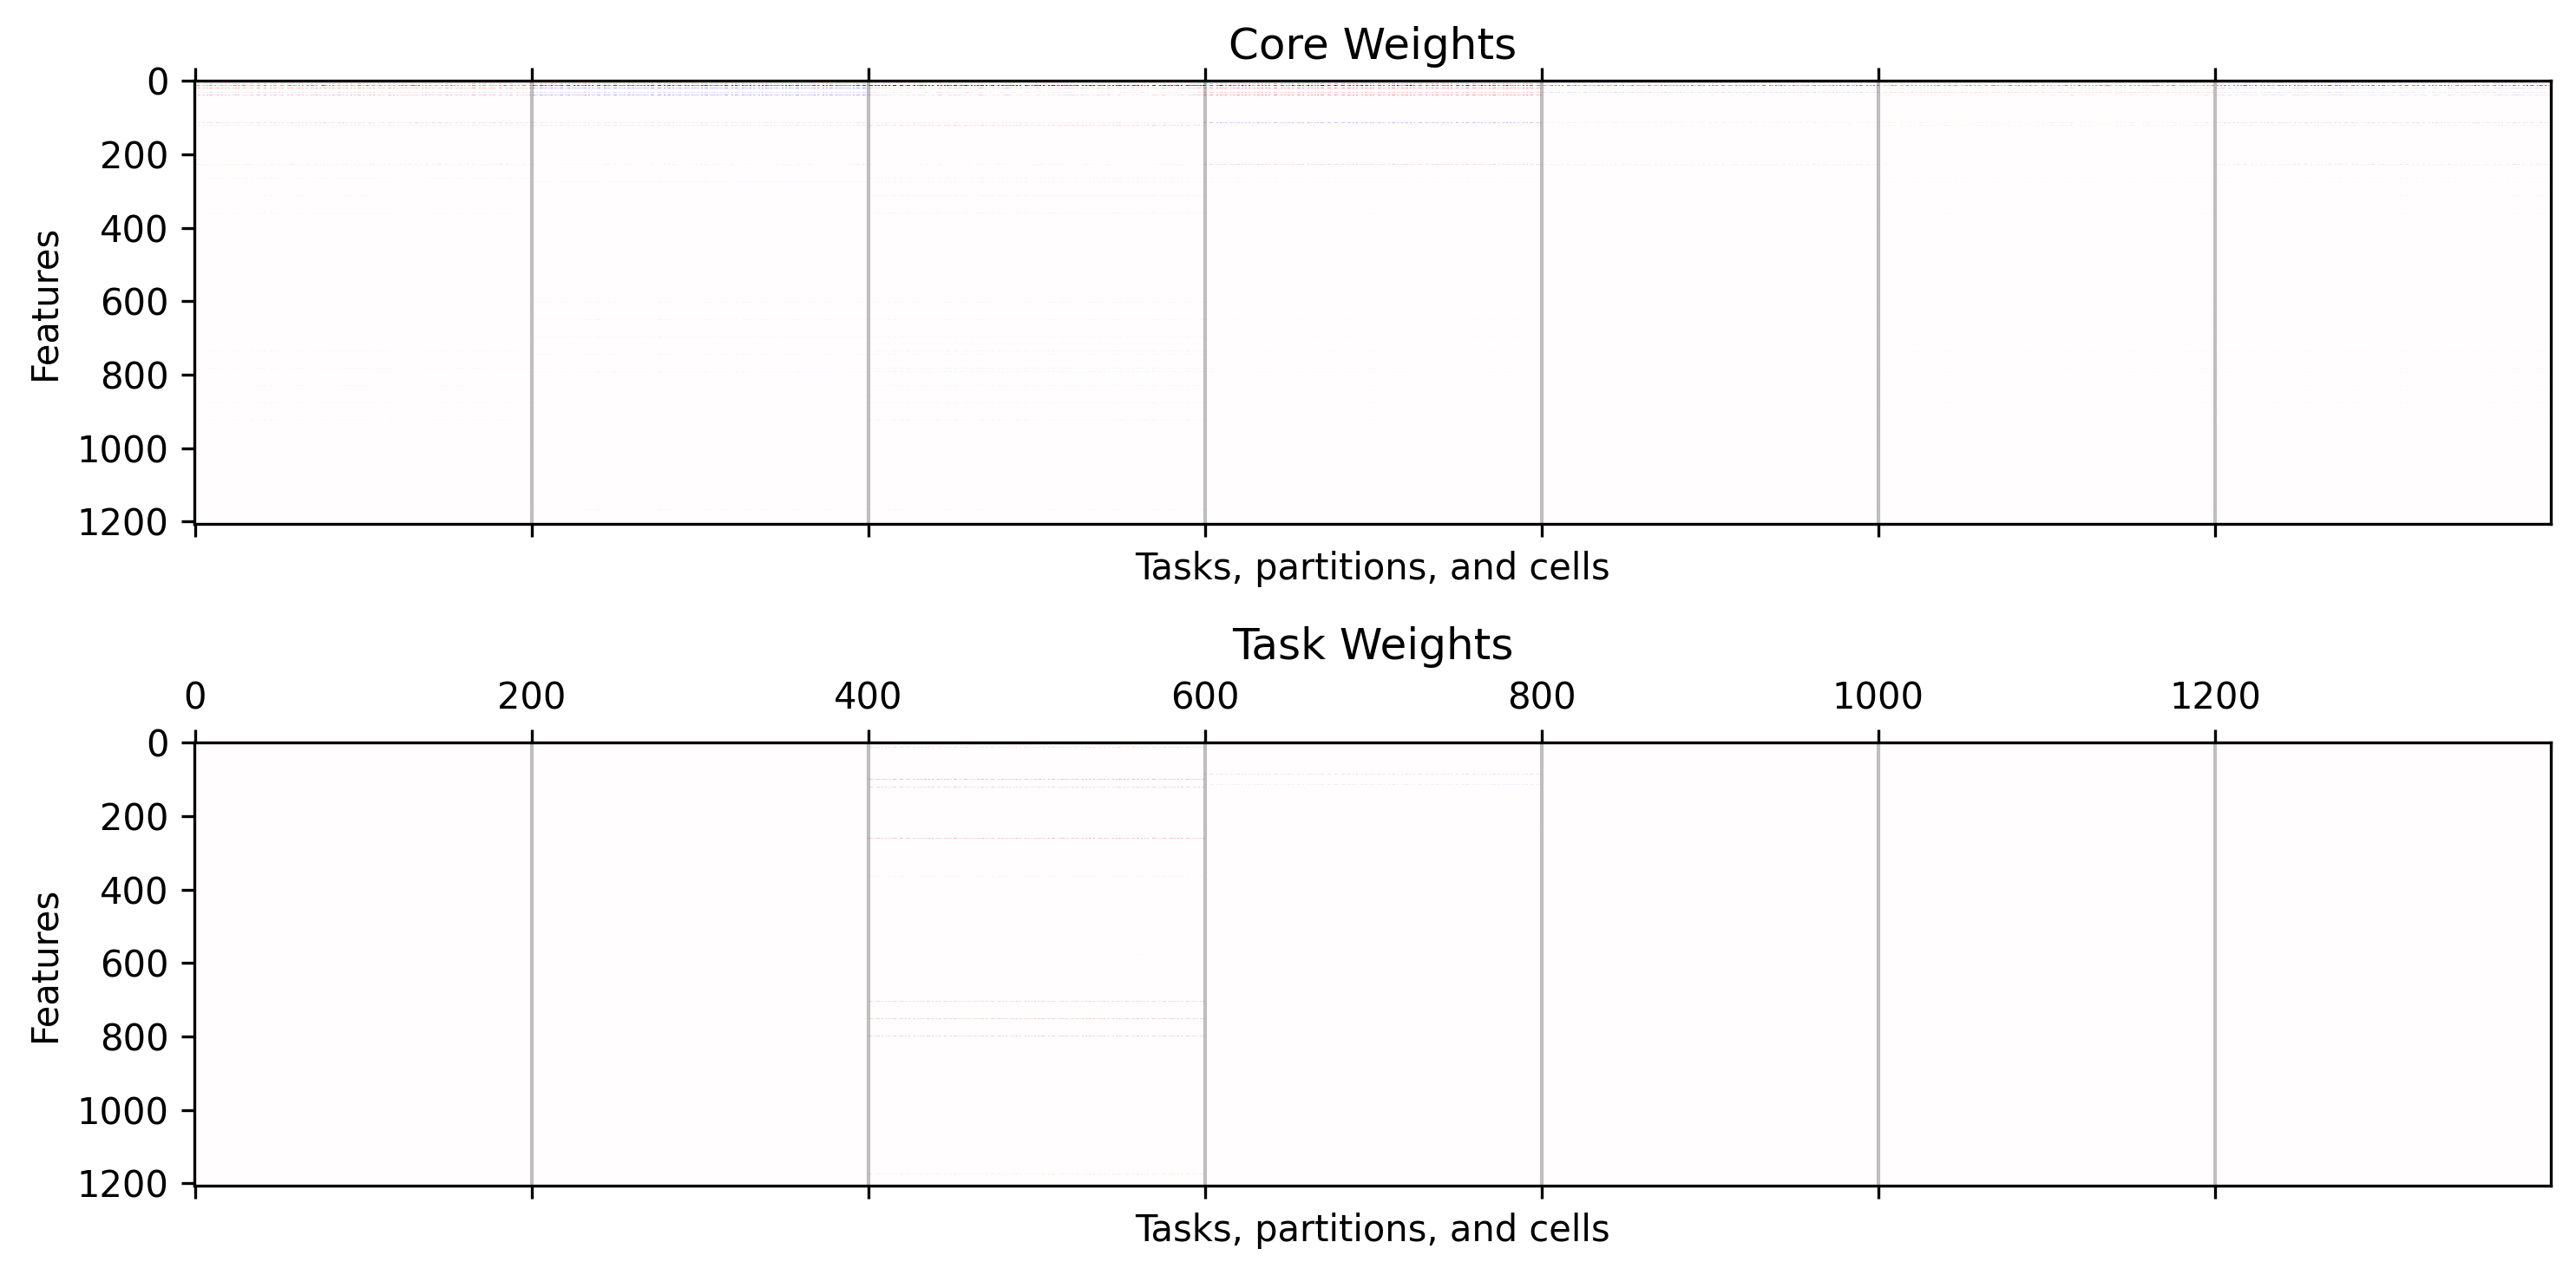

In [239]:
plot_joplen_weights(jp_model)

In [240]:
feature_mask = np.linalg.norm(jp_model.cwb.get(), axis=(0, 2))[:-1] > 1e-2
task_mask = np.linalg.norm(jp_model.cws.get(), axis=2)[:, :-1] > 1e-2
task_mask = task_mask & ~feature_mask
print(feature_mask.sum())
print(task_mask.sum(axis=1))

y_train_pred, y_val_pred, y_test_pred = [], [], []
y_train_err, y_val_err, y_test_err = [], [], []

for i in range(n_tasks):
    combined_mask = feature_mask | task_mask[i]

    lgbm = LGBMRegressor(random_state=0, verbose=-1)
    lgbm.fit(x_train[i][:, combined_mask], y_train[i])

    y_train_pred.append(lgbm.predict(x_train[i][:, combined_mask]))
    y_val_pred.append(lgbm.predict(x_val[i][:, combined_mask]))
    y_test_pred.append(lgbm.predict(x_test[i][:, combined_mask]))

    y_train_err.append(np.mean((y_train_pred[-1] - y_train[i]) ** 2))
    y_val_err.append(np.mean((y_val_pred[-1] - y_val[i]) ** 2))
    y_test_err.append(np.mean((y_test_pred[-1] - y_test[i]) ** 2))

print("Train:", list(np.around(y_train_err, 2)))
print("Val:  ", list(np.around(y_val_err, 2)))
print("Test: ", list(np.around(y_test_err, 2)))

83
[ 0  0 16  1  0  0  0]
Train: [0.06, 0.03, 0.16, 0.06, 0.12, 0.06, 0.2]
Val:   [0.63, 0.27, 0.28, 0.36, 0.48, 0.51, 0.81]
Test:  [0.63, 0.22, 0.28, 0.35, 0.59, 0.4, 0.86]


In [241]:
np.sum(feature_mask) + np.sum(task_mask)

100

In [242]:
from mutar import DirtyModel

x_train_out, y_train_out, train_mask_out = concat_datasets(x_train, y_train)
x_val_out, y_val_out, val_mask_out = concat_datasets(x_val, y_val)
x_test_out, y_test_out, test_mask_out = concat_datasets(x_test, y_test)

dl_model = DirtyModel(
    alpha=0.03,  # shared penalty
    beta=0.02,  # task-specific penalty
)
dl_model.fit(x_train_out, y_train_out, train_mask_out)

/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/mutar/solvers.py:44: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  warnings.warn('Objective did not converge.' +


DirtyModel(alpha=0.03, beta=0.02)

In [243]:
dl_feature_mask = np.linalg.norm(dl_model.coef_shared_.T, axis=0) > 1e-4
dl_task_mask = np.abs(dl_model.coef_specific_.T) > 1e-4
dl_task_mask = dl_task_mask & ~dl_feature_mask
print(dl_feature_mask.sum())
print(dl_task_mask.sum(axis=1))

dl_train_pred, dl_val_pred, dl_test_pred = [], [], []
dl_train_err, dl_val_err, dl_test_err = [], [], []

for i in range(n_tasks):
    combined_mask = dl_feature_mask | dl_task_mask[i]

    lgbm = LGBMRegressor(random_state=0, verbose=-1)
    lgbm.fit(x_train[i][:, combined_mask], y_train[i])

    dl_train_pred.append(lgbm.predict(x_train[i][:, combined_mask]))
    dl_val_pred.append(lgbm.predict(x_val[i][:, combined_mask]))
    dl_test_pred.append(lgbm.predict(x_test[i][:, combined_mask]))

    dl_train_err.append(np.mean((dl_train_pred[-1] - y_train[i]) ** 2))
    dl_val_err.append(np.mean((dl_val_pred[-1] - y_val[i]) ** 2))
    dl_test_err.append(np.mean((dl_test_pred[-1] - y_test[i]) ** 2))

print("Train:", list(np.around(dl_train_err, 2)))
print("Val:  ", list(np.around(dl_val_err, 2)))
print("Test: ", list(np.around(dl_test_err, 2)))

# 79
# [ 2  0 87  6  0  0  5]
# Train: [0.05, 0.03, 0.13, 0.04, 0.1, 0.07, 0.18]
# Val:   [0.55, 0.24, 0.26, 0.34, 0.3, 0.42, 0.77]
# Test:  [0.58, 0.19, 0.24, 0.36, 0.6, 0.34, 0.81]
# 179

17
[ 0  0 85  7  0  0  1]
Train: [0.17, 0.09, 0.15, 0.09, 0.25, 0.24, 0.31]
Val:   [0.59, 0.35, 0.26, 0.39, 0.4, 0.97, 0.77]
Test:  [0.61, 0.26, 0.25, 0.39, 0.43, 0.79, 0.83]


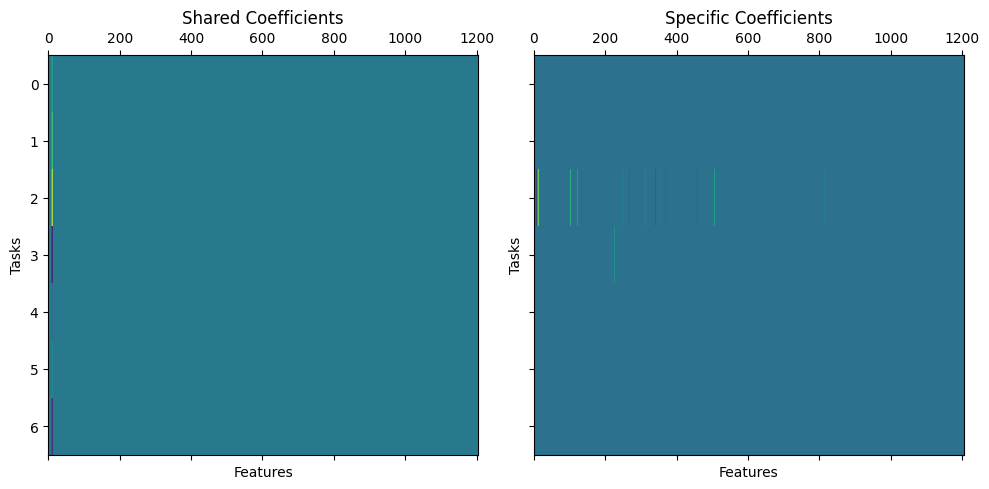

In [244]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)

axs[0].matshow(dl_model.coef_shared_.T, aspect="auto")
axs[0].set_title("Shared Coefficients")

axs[1].matshow(dl_model.coef_specific_.T, aspect="auto")
axs[1].set_title("Specific Coefficients")

for ax in axs:
    ax.set_xlabel("Features")
    ax.set_ylabel("Tasks")

plt.tight_layout()
plt.show()

In [248]:
np.sum(dl_feature_mask) + np.sum(dl_task_mask)

110

In [246]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor


def train_model(ModelClass, **kwargs):
    output = {}
    model = ModelClass(**kwargs)

    for i in tqdm(range(n_tasks)):
        model.fit(x_train[i], y_train[i])

        output[f"task {i}"] = {
            "train": np.mean((model.predict(x_train[i]) - y_train[i]) ** 2),
            "val": np.mean((model.predict(x_val[i]) - y_val[i]) ** 2),
            "test": np.mean((model.predict(x_test[i]) - y_test[i]) ** 2),
        }
    return output


linear_results = train_model(LinearRegression)
naive_results = train_model(DummyRegressor, strategy="mean")
lgbm_results = train_model(LGBMRegressor, random_state=0, verbose=-1)
linear_test_err = [linear_results[f"task {i}"]["test"] for i in range(n_tasks)]
naive_test_err = [naive_results[f"task {i}"]["test"] for i in range(n_tasks)]
lgbm_test_err = [lgbm_results[f"task {i}"]["test"] for i in range(n_tasks)]

100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


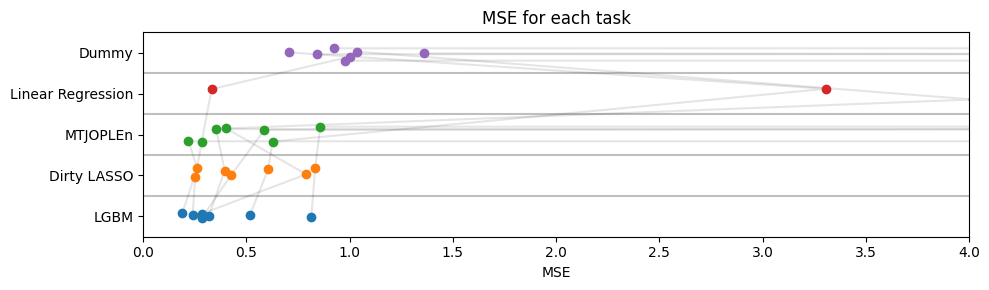

In [247]:
columns = ["train", "val", "test"]
index = [f"task {i}" for i in range(n_tasks)]

data = np.vstack(
    [lgbm_test_err, dl_test_err, y_test_err, linear_test_err, naive_test_err]
)

fig, ax = plt.subplots(figsize=(10, 3))

ax, y_values = plot_strip(
    data,
    scatter_kwargs={"marker": "o"},
    ax=ax,
)

ax.plot(data.reshape(5, -1), y_values, color="k", alpha=0.1, zorder=0)

ax.set_xlabel("MSE")
ax.set_yticks(
    range(5), ["LGBM", "Dirty LASSO", "MTJOPLEn", "Linear Regression", "Dummy"]
)
ax.set_title("MSE for each task")

ax.set_xlim(0, 4)
plt.tight_layout()
plt.show()

In [169]:
path = NANO_PATH / "logp" / "metadata.yaml"
metadata = yaml.load(path.read_text(), Loader=yaml.SafeLoader)
features = np.array(metadata["features"])

print("JOPLEn features")
print(features[feature_mask])
print()
print("DirtyLasso Features")
print(features[dl_feature_mask])

JOPLEn features
['mass_whim_rel_axis3' 'mass_whim_k' 'unweighted_cchn' 'mass_cchn'
 'vdw_volume_cchn' 'electronegativity_cchn' 'polarizability_cchn'
 'covalent_radius_cchn' 'electron_affinity_cchn' 'nvalence_cchn'
 'zeff_cchn' 'ionization_energy1_cchn' 'ionization_energy2_cchn'
 'ionization_energy3_cchn' 'melting_point_cchn' 'boiling_point_cchn'
 'thermal_conductivity_cchn' 'fusion_heat_cchn' 'evaporation_heat_cchn'
 'atomic_volume_cchn' 'density_cchn' 'specific_heat_cchn']

DirtyLasso Features
['vdw_volume_variance' 'electronegativity_variance'
 'electron_affinity_variance' 'ionization_energy1_variance'
 'mass_whim_rel_axis3' 'mass_whim_k' 'electron_affinity_whim_ax_density1'
 'vdw_volume_convhull_first_quartile'
 'electron_affinity_convhull_first_quartile' 'unweighted_cccc'
 'unweighted_ccch' 'unweighted_hhoo' 'mass_cccc' 'mass_ccch' 'mass_hhoo'
 'vdw_volume_cccc' 'vdw_volume_ccch' 'vdw_volume_hhoo'
 'electronegativity_ccch' 'polarizability_ccch' 'fusion_heat_hhhx']


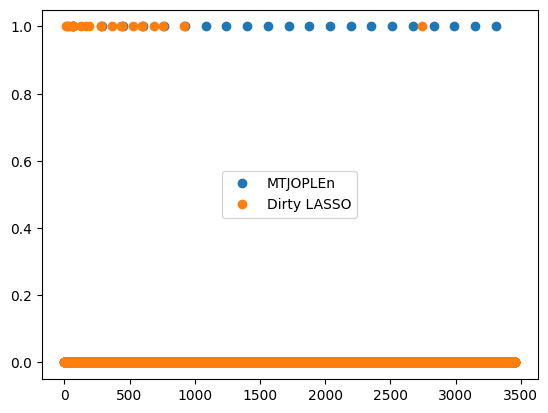

In [170]:
plt.plot(feature_mask, "o", label="MTJOPLEn")
plt.plot(dl_feature_mask, "o", label="Dirty LASSO")
plt.legend()